# Traffic sign classification(German) using LeNet based CNN

In this project, I'm building a model to classify the traffic signs.The model is trained using convolutional network based on the [LeNet](http://yann.lecun.com/exdb/lenet/) architecture by Yann LeCun. I'm using scikit-learn's pipeline framewok along with various combination of transformer and estimators.

## Approach
I'm building pipelines to classify the traffic signs. The project is explained in following sections:
* Data Analysis
* model Building and Implimentation
* Preprocessing
* Model Improvement
* Testing and Results

## Dataset Analysis

Dataset used is provided [here](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) <br>
Training data:(http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip)<br>
Test data    :(http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip)<br>

The training data set contains 39,209 training images in 43 classes. The test dataset contains 12,630 test images or the corresponding pre-calculated features in random order.

#### Training dataset strucutre:
Final_training
    + Images
        + 00000
            + 00000_00000.ppm
            + 00000_00001.ppm
            ...
            + GT-00000.csv
        + 00001
            + 00001_00000.ppm
            + 00001_00000.ppm
            ...
            + GT-00001.csv
        ...
        + 00042
            + 00042_00000.ppm
            + 00042_00001.ppm
            ...
            + GT-00042.csv
            
matplotlib and pillow both are required as the images are in .ppm format.

### Import required libraries

In [40]:
import glob
import requests
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import sys
#sys.path.append('/../path_to_pipeline_folder/')
from pipeline import NeuralNetwork, make_adam, Session, build_pipeline      #import from pipeline
matplotlib.style.use('ggplot')

#### loading Training Data


In [41]:
TRAIN_IMAGE_DIR='/home/krishna_warrior/Desktop/dataset30k'
dfs=[]
for train_file in glob.glob(os.path.join(TRAIN_IMAGE_DIR,'*/GT-*.csv')):
    folder=train_file.split('/')[5]      #actually my path contains 5 elements, configure according to your path
    df=pd.read_csv(train_file,sep=';')
    df['Filename']=df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGE_DIR,folder,x))
    dfs.append(df)

train_df=pd.concat(dfs,ignore_index=True)             #storing csv data in train_df
train_df.head()
#print(train_df)
df=pd.DataFrame(train_df)
df.to_csv("my_data1.csv",index=False)
#y= train_df['ClassId'][~np.isnan(train_df['ClassId'])]      #this is used to remove nan entries
df=pd.DataFrame(train_df['ClassId'])
df.to_csv("my_data.csv",index=False)

##### Dataframe structure:  
Filename: complete file name of corresponding images.<br>
Width,Height: weidth and height of images.<br>
Roi.X1: X-coordinate of top left corner of bounding box of traffic sign.<br>
Roi.Y1: y-coordinate of top left corner of bounding box of traffic sign.<br>
Roi.Y1: X-coordinate of bottom right corner of bounding box of traffic sign.<br>
Roi.Y1: Y-coordinate of bottom right corner of bounding box of traffic sign.<br>

The size of images are not fixed. The sign size and sign's center is also not fixed.<br>

### Class Distribution

In [42]:
N_CLASSES=np.unique(train_df['ClassId']).size   #no of classes
print("No. of training images: {:>5}".format(train_df.shape[0]))
print("No. of classes: {:>5}".format(N_CLASSES))

No. of training images: 39209
No. of classes:    43


There are 43 classes in 39,209 images.

Distribution of classes are as follows:

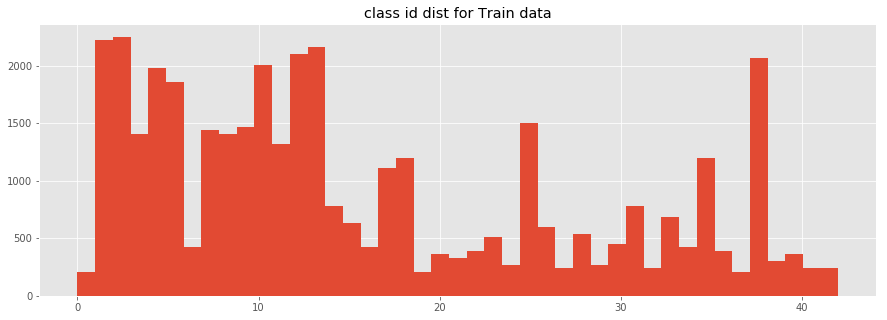

In [43]:
def class_dist(classIDs,title):            #maping data distribution with help  of matplotlib
    plt.figure(figsize=(15,5))
    plt.title('class id dist for {}'.format(title))
    plt.hist(classIDs,bins=N_CLASSES)
    plt.show()
    
class_dist(train_df['ClassId'],'Train data')

The names of signs according to classid are stored in sign_names.csv file.

In [44]:
sign_name_df=pd.read_csv('sign_names.csv',index_col='ClassId')       #getting sign name corresponding to classid
sign_name_df.head()
print(sign_name_df.head())

                     SignName
ClassId                      
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)


In [45]:
sign_name_df['Occurence']=[sum(train_df['ClassId']==c) for c in range(N_CLASSES)]      # add new colum 'Occurence' which stores no of images in a class.
sign_name_df.sort_values('Occurence',ascending=False)    #sort occurence in non ascending order
print(sign_name_df)                       #will show id,name,occurence of images.
SIGN_NAMES=sign_name_df.SignName.values         #store sign names value corresponding to id
#print(SIGN_NAMES[2])      #will  print speed limit 50 km/h

                                                  SignName  Occurence
ClassId                                                              
0                                     Speed limit (20km/h)        210
1                                     Speed limit (30km/h)       2220
2                                     Speed limit (50km/h)       2250
3                                     Speed limit (60km/h)       1410
4                                     Speed limit (70km/h)       1980
5                                     Speed limit (80km/h)       1860
6                              End of speed limit (80km/h)        420
7                                    Speed limit (100km/h)       1440
8                                    Speed limit (120km/h)       1410
9                                               No passing       1470
10            No passing for vehicles over 3.5 metric tons       2010
11                   Right-of-way at the next intersection       1320
12                  

#### Random sample images from dataset

these are some random images from dataset.

In [46]:
def load_image(image_file):
    return plt.imread(image_file)

In [47]:
def get_samples(image_data,num_samples,class_id=None):         #prepare sample images(VALIDATION)
    if class_id is not None:
        image_data=image_data[image_data['ClassId']==class_id]
    indices=np.random.choice(image_data.shape[0],size=num_samples,replace=False)   #randomly chosing images for validation
    return image_data.iloc[indices][['Filename','ClassId']].values

In [48]:
def show_images(image_data,cols=5,sign_names=None,show_shape=False,func=None):        #display all images in matrix form
    num_images=len(image_data)
    rows=num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i,(image_file,lable) in enumerate(image_data):
        image=load_image(image_file)
        if func is not None:
            image=func(image)
        plt.subplot(rows,cols,i+1)
        plt.imshow(image)
        if sign_names is not None:
            plt.text(0,0,'{}:{}'.format(lable,sign_names[lable]),color='k',backgroundcolor='c',fontsize=8)
        if show_shape:
            plt.text(0,image.shape[0],'{}'.format(image.shape),color='k',backgroundcolor='y',fontsize=8)
        plt.xticks([])
        plt.yticks([])
    plt.show()


Here is 30 random images from dataset.

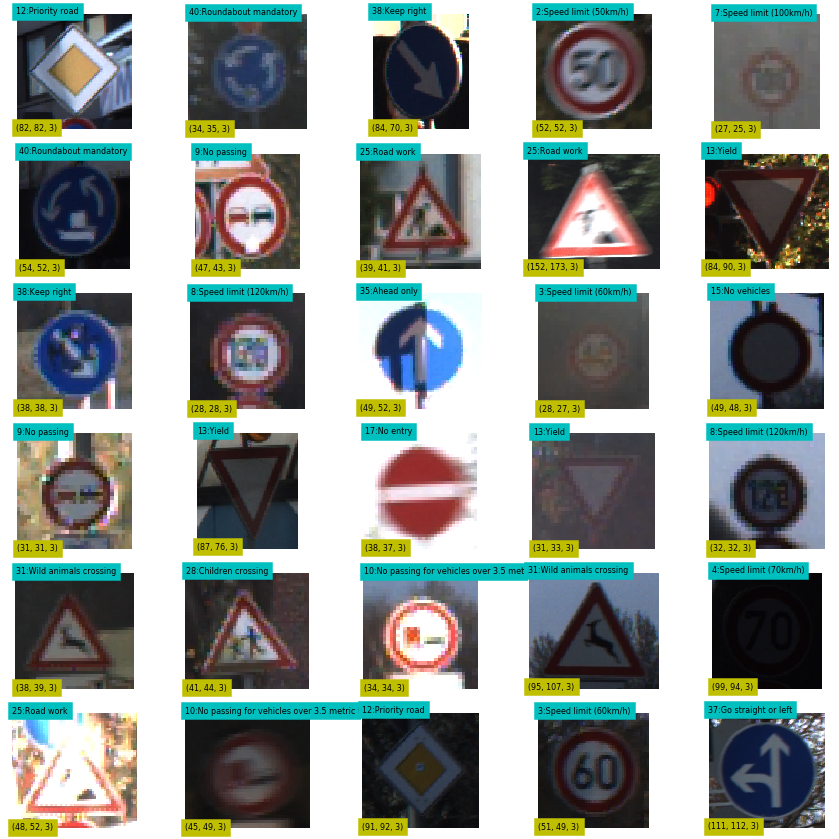

In [49]:
sample_data=get_samples(train_df,30)
show_images(sample_data,sign_names=SIGN_NAMES,show_shape=True)

Speed limit (30km/h)


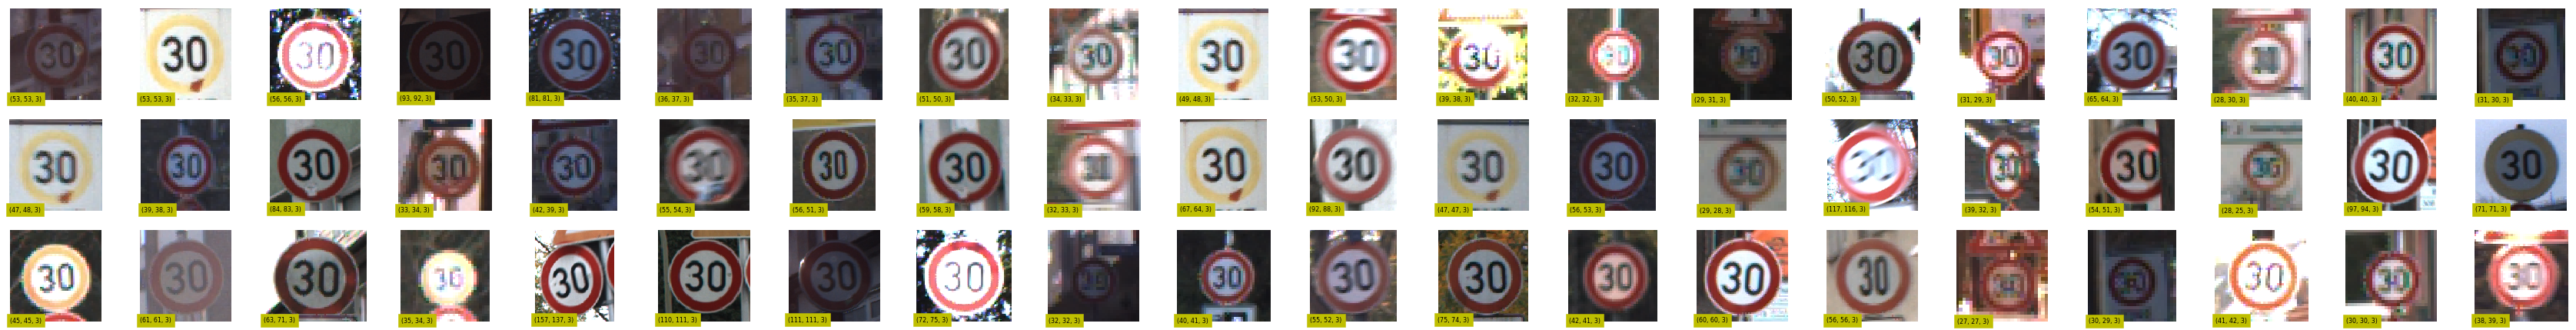

In [53]:
print(SIGN_NAMES[1])
show_images(get_samples(train_df,60,class_id=1),cols=20,show_shape=True)

##### Observations

* images are not of same sizes
* darkness/brightness of images are totally random
* images may not be exactly centered
* images may not be facing straight
* images may be slightly rotated

The above situations are handled in preprocessing(first point) and image augmentation. 

## Training and Validation

Let's create train and validate dataset.

In [51]:
X=train_df['Filename'].values
y=train_df['ClassId'].values
print('X data(total images):',len(X))

X data(total images): 39209


In [52]:
X_train, X_valid,y_train, y_valid=train_test_split(X,y,stratify=y,test_size=7000,random_state=0)      #i will use external validation images later
print('X_train:',len(X_train))
print('X_valid:',len(X_valid))

X_train: 32209
X_valid: 7000


# Model Implimentation

## Model Architecture

The model is based on [LeNet](http://yann.lecun.com/exdb/lenet/) by Yann LeCun. 

our model has following structure:  <br>
layer                     : shape    <br>
Input                     : 32x32x3  <br>
Convolution(valid, 5x5x6) : 28x28x9  <br>
Max Pooling(valid, 2x2)   : 14x14x6  <br>
Activation(ReLU)          : 14x14x6   <br>
Convolution(Valid, 5x5x16): 10x10x16  <br>
Max Pooling(valid, 2x2)   : 5x5x6    <br>
Activation(ReLU)          : 5x5x16    <br>
Flatten                   : 400      <br>
Dense                     : 120      <br>
Activation(ReLU)          : 120      <br>
Dense                     : 43        <br>
Activation(Softmax)       : 43        <br>  


Activation is ReLU except for output layer which uses Softmax.<br>
The output has 43 classes

## Model Implementation

The NeuralNetwork class defined in network.py provides common operations in neural network using tensorflow.

### Network 1
First network of our pipeline.

In [56]:
INPUT_SHAPE=(32,32,3)
def network1(input_shape=INPUT_SHAPE):            
    return(NeuralNetwork()
           .input(input_shape)
           .conv([5,5,6])      #filters in conv. layer
           .max_pool()
           .relu()
           .conv([5,5,16])
           .max_pool()
           .relu()
           .flatten()
           .dense(120)        #neurons in dense layer
           .relu()
           .dense(N_CLASSES))

### Pipeline Implementation
scikit-learn's pipeline framework is used to handel various pipeline scenarios. pipeline.py contains various functions necessory for implementation of pipeline.<br>
following function is used for training pipeline.

In [63]:
def train_evaluate(pipeline,epochs=5,samples_per_epoch=50000,train=(X_train,y_train),test=(X_valid, y_valid)):     #here 50000 is used to increase accuracy(more iterations)
    X,y=train
    learning_curve=[]
    for i in range (epochs):
        indices=np.random.choice(len(X),size=samples_per_epoch)       #did u get the use of np.random() ?
        pipeline.fit(X[indices],y[indices])
        scores=[pipeline.score(*train),pipeline.score(*test)]
        learning_curve.append([i,*scores])
        print("Epoch: {:>3} Training score: {:.3f} Evaluation score: {:.3f}".format(i,*scores))
    return np.array(learning_curve).T

#### Network1 performance
this is training and performance of first network. It will be used as initial benchmark.

In [58]:
def resize_image(image,shape=INPUT_SHAPE[:2]):
    return cv2.resize(image,shape)
loader=lambda image_file: resize_image(load_image(image_file))

In [59]:
with Session() as session:
    functions=[loader]
    pipeline=build_pipeline(functions,session, network1(),make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Training score: 0.877 Evaluation score: 0.870
Epoch:   1 Training score: 0.935 Evaluation score: 0.916
Epoch:   2 Training score: 0.963 Evaluation score: 0.936
Epoch:   3 Training score: 0.946 Evaluation score: 0.925
Epoch:   4 Training score: 0.936 Evaluation score: 0.918
Epoch:   5 Training score: 0.950 Evaluation score: 0.925
Epoch:   6 Training score: 0.981 Evaluation score: 0.955
Epoch:   7 Training score: 0.951 Evaluation score: 0.930
Epoch:   8 Training score: 0.968 Evaluation score: 0.949
Epoch:   9 Training score: 0.971 Evaluation score: 0.945


#### Observation

The network is working fine. Performance appears to be quite good. It is showing some overfitting issue though(due to less no. of epochs).

## Preprocessing

The preprocessing techniques includes normaliZation, image augmentation and color space variation.

#### Image Augmentation
To prevent overfitting we should increase training data using image augmentation.

In [67]:
def rBrightness(image,ratio):
    hsv=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    brightness=np.float64(hsv[:, :, 2])
    brightness=brightness*(1.0+np.random.uniform(-ratio,ratio))
    brightness[brightness>255]=255
    brightness[brightness<0]=0
    hsv[:, :, 2]=brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
def rRotation(image, angle):
    if angle==0:
        return image
    angle=np.random.uniform(-angle,angle)
    rows,cols=image.shape[:2]
    size=rows,cols
    center=rows/2,cols/2
    scale=1.0
    rotation=cv2.getRotationMatrix2D(center,angle,scale)
    return cv2.warpAffine(image,rotation,size)
def rTranslation(image, translation):
    if translation==0:
        return 0
    rows,cols=image.shape[:2]
    size=rows,cols
    x=np.random.uniform(-translation,translation)
    y=np.random.uniform(-translation,translation)
    trans=np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image,trans,size)
def rShear(image, shear):
    if shear==0:
        return image
    rows,cols=image.shape[:2]
    size=rows,cols
    left,right,top,bottom=shear,cols-shear,shear,rows-shear
    dx=np.random.uniform(-shear,shear)
    dy=np.random.uniform(-shear,shear)
    p1=np.float32([[left,top],[right,top],[left,bottom]])
    p2=np.float32([[left+dx,top],[right+dx,top+dy],[left,bottom+dy]])
    move=cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image,move,size)
def agument_image(image,brightness,angle,translation,shear):
    image=rBrightness(image,brightness)
    image=rRotation(image,angle)
    image=rTranslation(image,translation)
    image=rShear(image,shear)
    return image
augmenter=lambda x: agument_image(x,0.7,11,5,2)

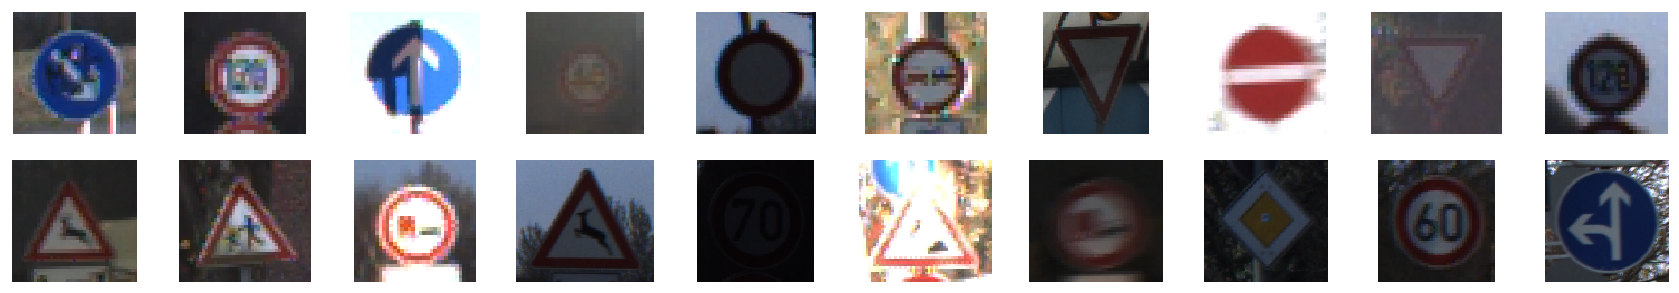

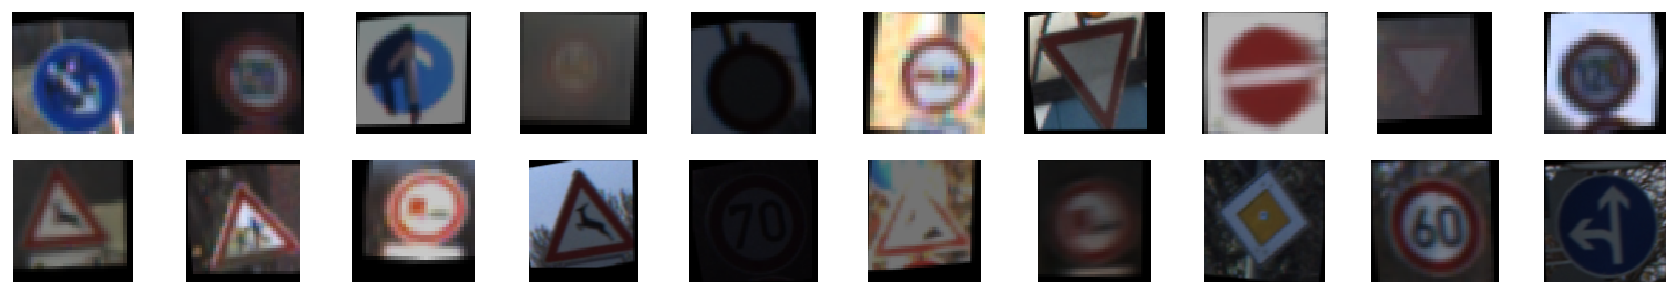

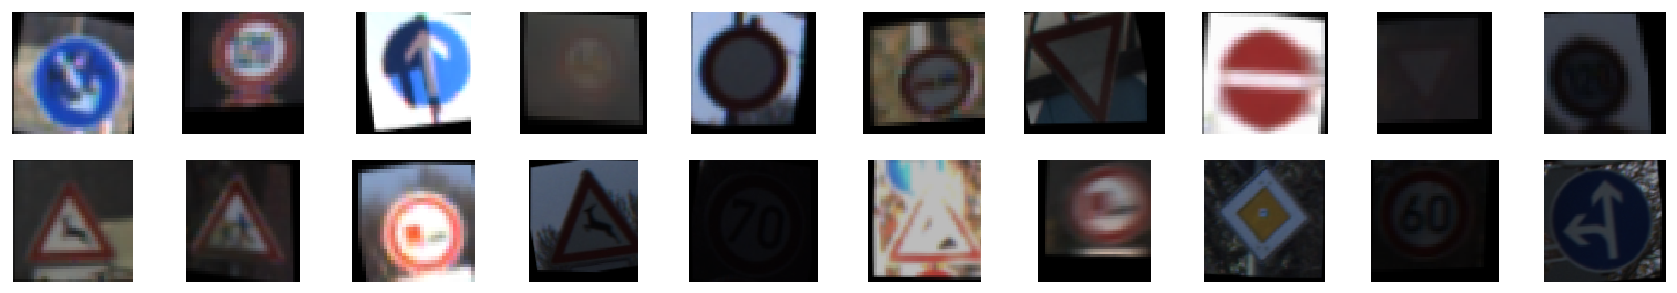

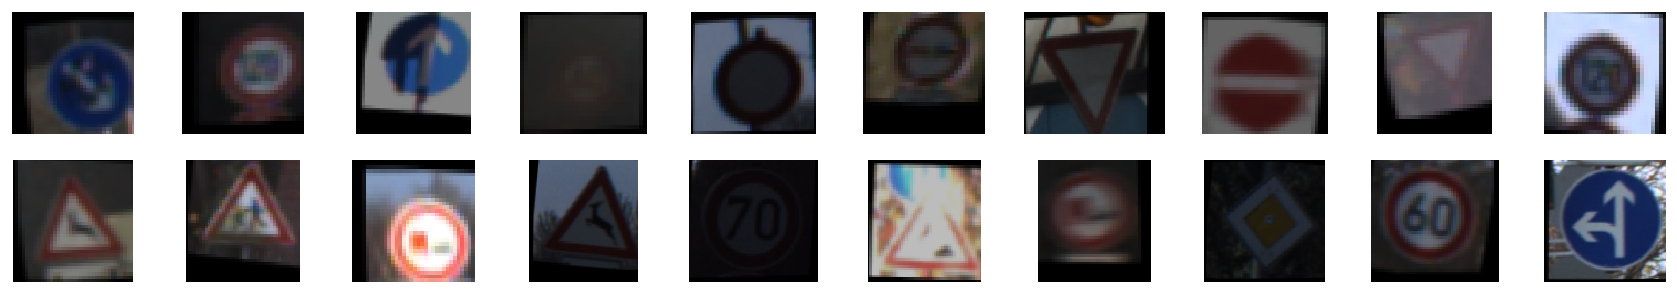

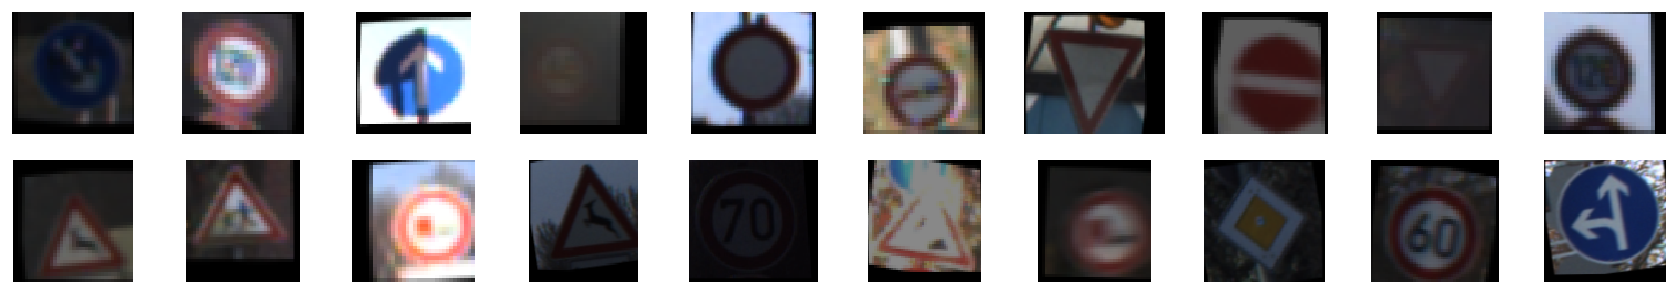

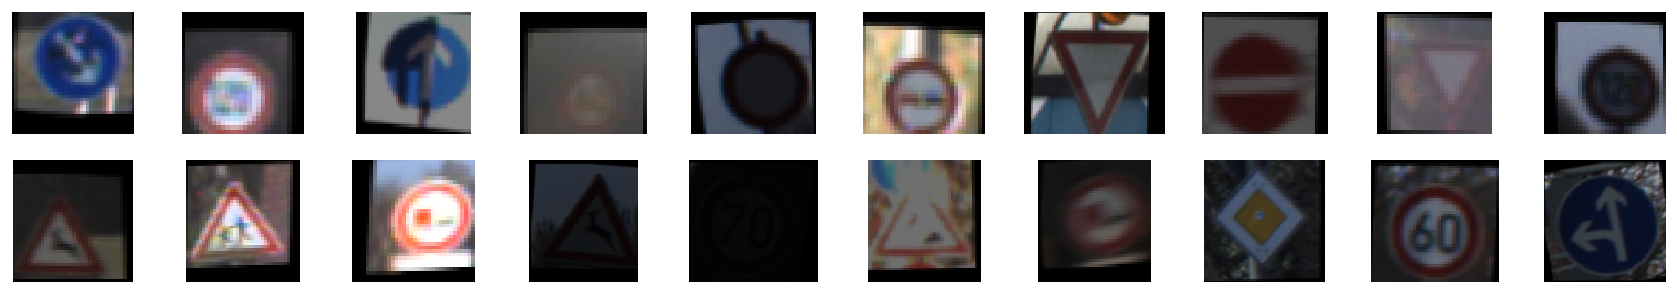

In [68]:
show_images(sample_data[10:],cols=10)
for i in range(5):
    show_images(sample_data[10:],cols=10,func=augmenter)

In [69]:
with Session() as session:
    functions=[loader,augmenter]
    pipeline=build_pipeline(functions,session, network1(),make_adam(1.0e-3))
    train_evaluate(pipeline)

Epoch:   0 Training score: 0.336 Evaluation score: 0.333
Epoch:   1 Training score: 0.472 Evaluation score: 0.467
Epoch:   2 Training score: 0.600 Evaluation score: 0.604
Epoch:   3 Training score: 0.655 Evaluation score: 0.652
Epoch:   4 Training score: 0.670 Evaluation score: 0.666


##### observation
The performance is much worse with augmentation than without it.<br>
Possible reasons:<br>
1.training requires more epochs<br>
2.network is not robust to these changes.<br>
Normilization and other techniques should be helpful in improving learning and training.
#### Normilization
Below are various normilizer techniques.

In [72]:
normalizers=[('x-127.5', lambda x: x-127.5),('x/127.5-1.0', lambda x: x/127.5-1.0),
           ('x/225.0-0.5',lambda x: x/225.0-0.5),('x-x.mean()',lambda x: x-x.mean()),
           ('(x-x.mean())/x.std()', lambda x: (x-x.mean())/x.std())]
for name, normalizer in normalizers:
    print('Normalizer: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, normalizer]
        pipeline = build_pipeline(functions, session, network1(), make_adam(1.0e-3))
        train_evaluate(pipeline)
    print()

Normalizer: x-127.5
Epoch:   0 Training score: 0.390 Evaluation score: 0.381
Epoch:   1 Training score: 0.571 Evaluation score: 0.569
Epoch:   2 Training score: 0.574 Evaluation score: 0.582
Epoch:   3 Training score: 0.651 Evaluation score: 0.648
Epoch:   4 Training score: 0.705 Evaluation score: 0.699

Normalizer: x/127.5-1.0
Epoch:   0 Training score: 0.556 Evaluation score: 0.562
Epoch:   1 Training score: 0.706 Evaluation score: 0.706
Epoch:   2 Training score: 0.763 Evaluation score: 0.758
Epoch:   3 Training score: 0.794 Evaluation score: 0.794
Epoch:   4 Training score: 0.818 Evaluation score: 0.813

Normalizer: x/225.0-0.5
Epoch:   0 Training score: 0.536 Evaluation score: 0.534
Epoch:   1 Training score: 0.719 Evaluation score: 0.722
Epoch:   2 Training score: 0.776 Evaluation score: 0.770
Epoch:   3 Training score: 0.817 Evaluation score: 0.813
Epoch:   4 Training score: 0.833 Evaluation score: 0.834

Normalizer: x-x.mean()
Epoch:   0 Training score: 0.491 Evaluation score: 

##### Observations
Out of all methods (x-x.mean())/x.std() performed best. Also one thing is noticible that the performance without normalization is little better than with normalization.

there are few other methods such as using an average image of all training data, etc, which I would like to try later.

In [73]:
normalizer=lambda x: (x-x.mean())/x.std()

#### Color Space
Now we will try some color spaces such as YUV, Gray scale etc.<br>
(as gray scale has only one channel so it needs to handle seperately).

In [74]:
converters = [('Gray', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)[:, :, np.newaxis]),
              ('HSV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HSV)),
              ('HLS', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HLS)),
              ('Lab', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Lab)),
              ('Luv', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Luv)),
              ('XYZ', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2XYZ)),
              ('Yrb', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YCrCb)),
              ('YUV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))]
GRAY_INPUT_SHAPE = (*INPUT_SHAPE[:2], 1)

In [75]:
for name, converter in converters:
    print('Color Space: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, converter, normalizer]
        if name == 'Gray':
            network = network1(input_shape=GRAY_INPUT_SHAPE) # there is only one channel in gray scale
        else:
            network = network1()
        pipeline = build_pipeline(functions, session, network, make_adam(1.0e-3))
        train_evaluate(pipeline)
    print()

Color Space: Gray
Epoch:   0 Training score: 0.698 Evaluation score: 0.705
Epoch:   1 Training score: 0.801 Evaluation score: 0.800
Epoch:   2 Training score: 0.861 Evaluation score: 0.860
Epoch:   3 Training score: 0.883 Evaluation score: 0.883
Epoch:   4 Training score: 0.899 Evaluation score: 0.894

Color Space: HSV
Epoch:   0 Training score: 0.520 Evaluation score: 0.517
Epoch:   1 Training score: 0.615 Evaluation score: 0.612
Epoch:   2 Training score: 0.685 Evaluation score: 0.679
Epoch:   3 Training score: 0.746 Evaluation score: 0.739
Epoch:   4 Training score: 0.788 Evaluation score: 0.785

Color Space: HLS
Epoch:   0 Training score: 0.484 Evaluation score: 0.487
Epoch:   1 Training score: 0.642 Evaluation score: 0.649
Epoch:   2 Training score: 0.730 Evaluation score: 0.723
Epoch:   3 Training score: 0.788 Evaluation score: 0.783
Epoch:   4 Training score: 0.823 Evaluation score: 0.822

Color Space: Lab
Epoch:   0 Training score: 0.587 Evaluation score: 0.584
Epoch:   1 Train

KeyboardInterrupt: 

###### Observations
 The performance is worse than without colorspace.<br>
 I was expecting gray scale to give better performance. I am not using any colorspace for now.<br> 
 
 preprocessing part is done now.

In [76]:
preprocessors = [loader,augmenter, normalizer]

### Model Improvement

Here I will try to improve the model by doing following changes:
* adding more filters in conv layer
* more neurons in dense layer
* more conv layers
* more dense layers
* different activation like softmax, elu instead of relu
* dropout

plot of learning curve: 

In [78]:
def show_learning_curve(learning_curve):
    epochs, train, valid = learning_curve
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train, label='train')
    plt.plot(epochs, valid, label='validation')
    plt.title('Learning Curve')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.xticks(epochs)
    plt.legend(loc='center right')

Function for plotting confusion matrix:

In [79]:
def plot_confusion_matrix(cm):
    cm = [row/sum(row)   for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()
def print_confusion_matrix(cm, sign_names=SIGN_NAMES):
    results = [(i, SIGN_NAMES[i], row[i]/sum(row)*100) for i, row in enumerate(cm)]
    accuracies = []
    for result in sorted(results, key=lambda x: -x[2]):
        print('{:>2} {:<50} {:6.2f}% {:>4}'.format(*result, sum(y_train==result[0])))
        accuracies.append(result[2])
    print('-'*50)
    print('Accuracy: Mean: {:.3f} Std: {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))

## Network 2

Doubling filters in conv layer and neurons in dense layer.

In [80]:
def make_network2(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 12])  # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 32])  # <== doubled
            .max_pool()
            .relu()
            .flatten()
            .dense(240) # <== doubled
            .relu()
            .dense(N_CLASSES))

Epoch:   0 Training score: 0.855 Evaluation score: 0.850
Epoch:   1 Training score: 0.909 Evaluation score: 0.910
Epoch:   2 Training score: 0.943 Evaluation score: 0.943
Epoch:   3 Training score: 0.953 Evaluation score: 0.949
Epoch:   4 Training score: 0.953 Evaluation score: 0.952
INFO:tensorflow:Restoring parameters from checkpoint/network2.ckpt


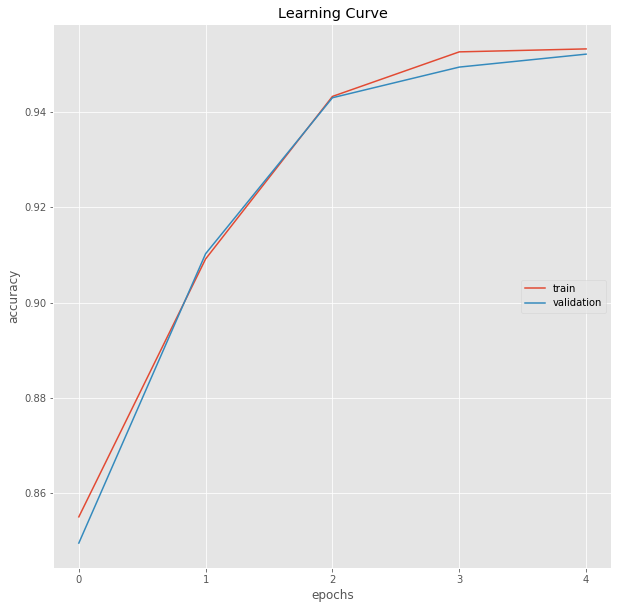

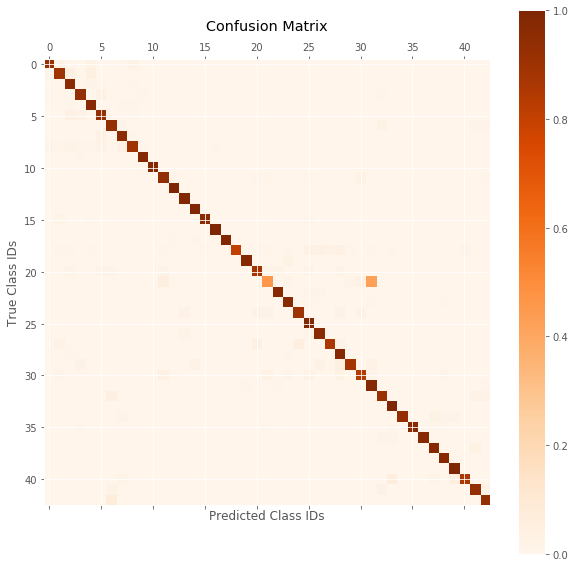

14 Stop                                               100.00%  641
16 Vehicles over 3.5 metric tons prohibited           100.00%  345
33 Turn right ahead                                   100.00%  566
39 Keep left                                          100.00%  246
12 Priority road                                       99.73% 1725
25 Road work                                           99.25% 1232
17 No entry                                            98.99%  912
13 Yield                                               98.96% 1774
10 No passing for vehicles over 3.5 metric tons        98.61% 1651
 9 No passing                                          98.09% 1208
28 Children crossing                                   97.92%  444
31 Wild animals crossing                               97.84%  641
38 Keep right                                          97.57% 1700
19 Dangerous curve to the left                         97.37%  172
37 Go straight or left                                 97.37% 

In [82]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network2(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline)
    session.save('checkpoint/network2.ckpt')

show_learning_curve(learning_curve)

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network2())
    session.load('checkpoint/network2.ckpt')
    pred = pipeline.predict(X_valid)
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

##### Observation:
the performance is better. Little overfitting here as training accuracy is little higher than evaluation accuracy which i hope will be reduce bu increasing complexity of network and number of epochs.

## Network 3
further doubling all filters in conv layer and neurons in dense layer.

Epoch:   0 Training score: 0.895 Evaluation score: 0.892
Epoch:   1 Training score: 0.936 Evaluation score: 0.932
Epoch:   2 Training score: 0.956 Evaluation score: 0.950
Epoch:   3 Training score: 0.961 Evaluation score: 0.957
Epoch:   4 Training score: 0.960 Evaluation score: 0.959
INFO:tensorflow:Restoring parameters from checkpoint/network3.ckpt


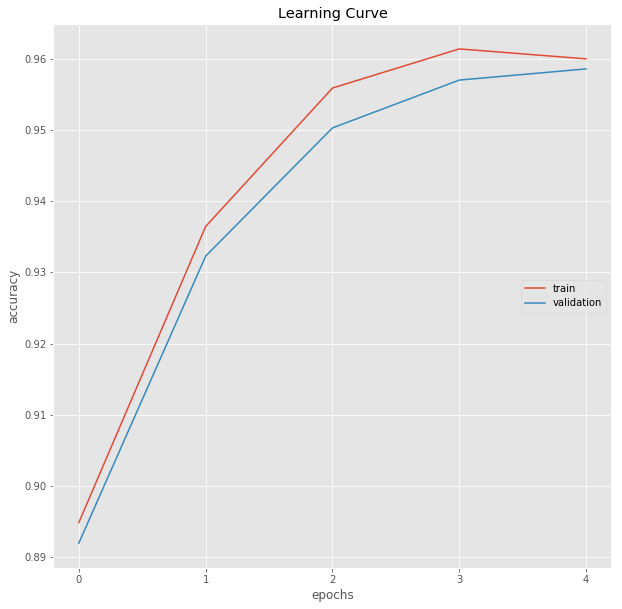

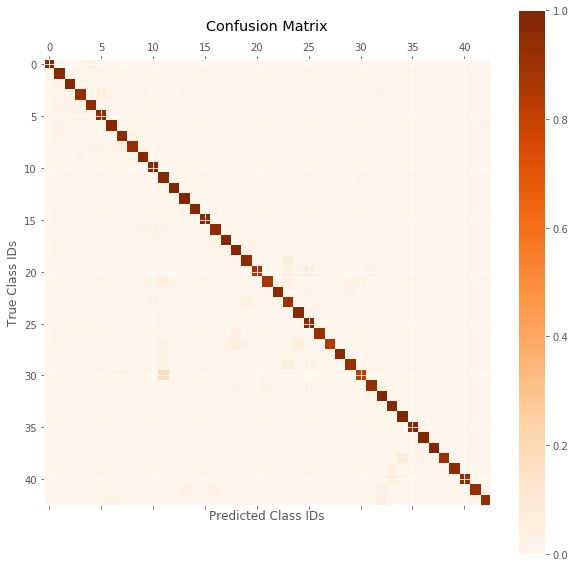

12 Priority road                                      100.00% 1725
32 End of all speed and passing limits                100.00%  197
34 Turn left ahead                                    100.00%  345
37 Go straight or left                                100.00%  172
10 No passing for vehicles over 3.5 metric tons        99.72% 1651
35 Ahead only                                          99.53%  986
13 Yield                                               99.48% 1774
33 Turn right ahead                                    99.19%  566
11 Right-of-way at the next intersection               98.73% 1084
18 General caution                                     98.60%  986
36 Go straight or right                                98.57%  320
25 Road work                                           98.51% 1232
17 No entry                                            98.48%  912
 2 Speed limit (50km/h)                                98.26% 1848
15 No vehicles                                         98.21% 

In [84]:
def make_network3(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24]) # <== doubled
            .max_pool()
            .relu()
            .conv([5, 5, 64]) # <== doubled
            .max_pool()
            .relu()
            .flatten()
            .dense(480)  # <== doubled
            .relu()
            .dense(N_CLASSES))
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline)
    session.save('checkpoint/network3.ckpt')

show_learning_curve(learning_curve)
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3.ckpt')
    pred = pipeline.predict(X_valid)
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

##### Observation:
Performance is much better.Little overfitting here but it's much less than before.Increasing no. of epochs must help.<br>
The accuracy is hiegher than 90% for most of case so it proves that increasing network complexity is making it more robust.<br>

I am going to do it with even more epochs.

## Network3 with more epochs

Epoch:   0 Training score: 0.886 Evaluation score: 0.885
Epoch:   1 Training score: 0.946 Evaluation score: 0.948
Epoch:   2 Training score: 0.949 Evaluation score: 0.947
Epoch:   3 Training score: 0.962 Evaluation score: 0.961
Epoch:   4 Training score: 0.968 Evaluation score: 0.964
Epoch:   5 Training score: 0.969 Evaluation score: 0.969
Epoch:   6 Training score: 0.973 Evaluation score: 0.971
Epoch:   7 Training score: 0.967 Evaluation score: 0.964
Epoch:   8 Training score: 0.967 Evaluation score: 0.963
Epoch:   9 Training score: 0.972 Evaluation score: 0.971
Epoch:  10 Training score: 0.978 Evaluation score: 0.977
Epoch:  11 Training score: 0.979 Evaluation score: 0.978
Epoch:  12 Training score: 0.986 Evaluation score: 0.981
Epoch:  13 Training score: 0.979 Evaluation score: 0.977
Epoch:  14 Training score: 0.982 Evaluation score: 0.980
Epoch:  15 Training score: 0.986 Evaluation score: 0.981
Epoch:  16 Training score: 0.982 Evaluation score: 0.979
Epoch:  17 Training score: 0.98

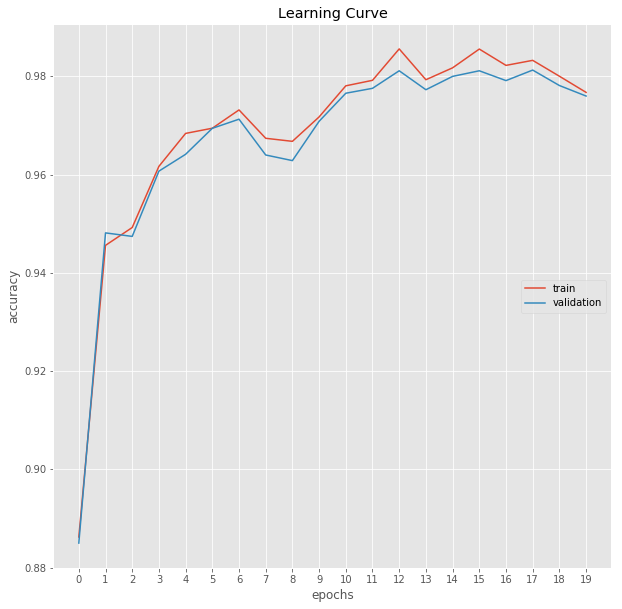

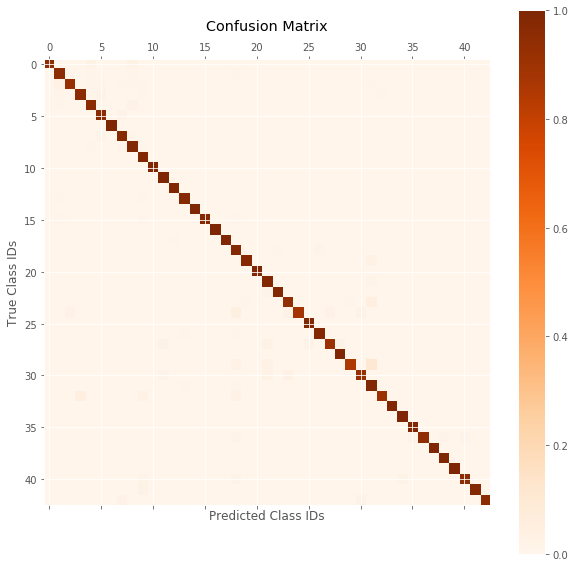

 6 End of speed limit (80km/h)                        100.00%  345
11 Right-of-way at the next intersection              100.00% 1084
12 Priority road                                      100.00% 1725
14 Stop                                               100.00%  641
16 Vehicles over 3.5 metric tons prohibited           100.00%  345
20 Dangerous curve to the right                       100.00%  296
28 Children crossing                                  100.00%  444
33 Turn right ahead                                   100.00%  566
34 Turn left ahead                                    100.00%  345
35 Ahead only                                         100.00%  986
37 Go straight or left                                100.00%  172
39 Keep left                                          100.00%  246
38 Keep right                                          99.73% 1700
10 No passing for vehicles over 3.5 metric tons        99.72% 1651
17 No entry                                            99.49% 

In [85]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_epochs-20.ckpt')
    
show_learning_curve(learning_curve)
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-20.ckpt')  
    pred = pipeline.predict(X_valid)
    
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

##### Observations:
Performance did improved but not in last several epochs.
let's try with even smaller rate.

## Network 3 (lower learning rate)
rate=(0.5e-3), epochs=20

In [86]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_e-20_lr-0.5e-3.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Training score: 0.832 Evaluation score: 0.823
Epoch:   1 Training score: 0.919 Evaluation score: 0.912
Epoch:   2 Training score: 0.953 Evaluation score: 0.954
Epoch:   3 Training score: 0.956 Evaluation score: 0.953
Epoch:   4 Training score: 0.977 Evaluation score: 0.976
Epoch:   5 Training score: 0.980 Evaluation score: 0.977
Epoch:   6 Training score: 0.975 Evaluation score: 0.974
Epoch:   7 Training score: 0.979 Evaluation score: 0.975
Epoch:   8 Training score: 0.973 Evaluation score: 0.972
Epoch:   9 Training score: 0.979 Evaluation score: 0.974
Epoch:  10 Training score: 0.983 Evaluation score: 0.979
Epoch:  11 Training score: 0.984 Evaluation score: 0.980
Epoch:  12 Training score: 0.982 Evaluation score: 0.981
Epoch:  13 Training score: 0.984 Evaluation score: 0.981
Epoch:  14 Training score: 0.989 Evaluation score: 0.986
Epoch:  15 Training score: 0.989 Evaluation score: 0.983
Epoch:  16 Training score: 0.991 Evaluation score: 0.987
Epoch:  17 Training score: 0.98

INFO:tensorflow:Restoring parameters from checkpoint/network3_e-20_lr-0.5e-3.ckpt


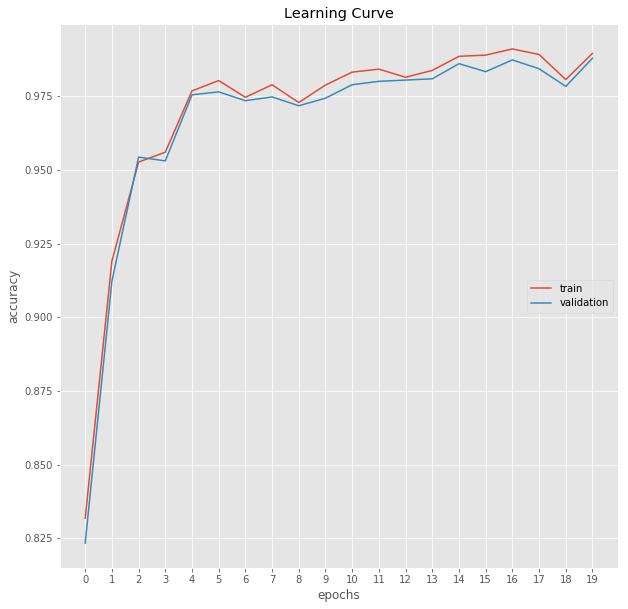

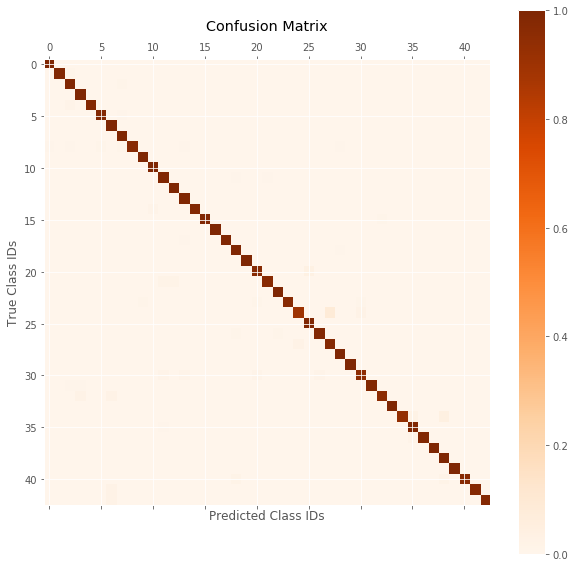

 0 Speed limit (20km/h)                               100.00%  173
 3 Speed limit (60km/h)                               100.00% 1158
 6 End of speed limit (80km/h)                        100.00%  345
10 No passing for vehicles over 3.5 metric tons       100.00% 1651
12 Priority road                                      100.00% 1725
16 Vehicles over 3.5 metric tons prohibited           100.00%  345
19 Dangerous curve to the left                        100.00%  172
22 Bumpy road                                         100.00%  320
28 Children crossing                                  100.00%  444
29 Bicycles crossing                                  100.00%  222
33 Turn right ahead                                   100.00%  566
37 Go straight or left                                100.00%  172
38 Keep right                                         100.00% 1700
39 Keep left                                          100.00%  246
 9 No passing                                          99.62% 

In [87]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_e-20_lr-0.5e-3.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

##### Observations:
The performance is best among all till now. Smaller learning rate produces good output.<br>
Let's try with even smaller learning rate.

## Network 3 with even smaller learning rate (lr=1.0e-4)
learning rate=1.0e-4, epochs=20.

In [90]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(1.0e-4)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network3_e-20_lr-1.0e-4.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Training score: 0.544 Evaluation score: 0.541
Epoch:   1 Training score: 0.715 Evaluation score: 0.714
Epoch:   2 Training score: 0.788 Evaluation score: 0.793
Epoch:   3 Training score: 0.839 Evaluation score: 0.836
Epoch:   4 Training score: 0.867 Evaluation score: 0.859
Epoch:   5 Training score: 0.885 Evaluation score: 0.881
Epoch:   6 Training score: 0.915 Evaluation score: 0.907
Epoch:   7 Training score: 0.925 Evaluation score: 0.918
Epoch:   8 Training score: 0.938 Evaluation score: 0.930
Epoch:   9 Training score: 0.942 Evaluation score: 0.939
Epoch:  10 Training score: 0.951 Evaluation score: 0.946
Epoch:  11 Training score: 0.953 Evaluation score: 0.952
Epoch:  12 Training score: 0.962 Evaluation score: 0.957
Epoch:  13 Training score: 0.962 Evaluation score: 0.956
Epoch:  14 Training score: 0.964 Evaluation score: 0.956
Epoch:  15 Training score: 0.969 Evaluation score: 0.964
Epoch:  16 Training score: 0.969 Evaluation score: 0.962
Epoch:  17 Training score: 0.97

INFO:tensorflow:Restoring parameters from checkpoint/network3_e-20_lr-1.0e-4.ckpt


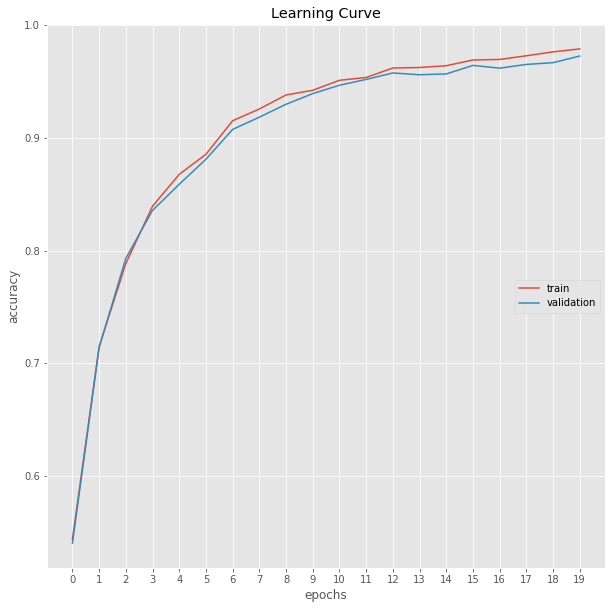

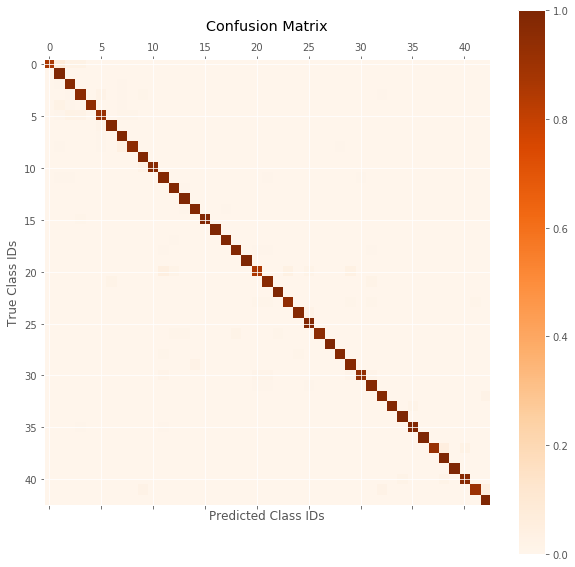

16 Vehicles over 3.5 metric tons prohibited           100.00%  345
19 Dangerous curve to the left                        100.00%  172
22 Bumpy road                                         100.00%  320
27 Pedestrians                                        100.00%  197
34 Turn left ahead                                    100.00%  345
36 Go straight or right                               100.00%  320
38 Keep right                                         100.00% 1700
39 Keep left                                          100.00%  246
42 End of no passing by vehicles over 3.5 metric tons 100.00%  197
13 Yield                                               99.74% 1774
17 No entry                                            99.49%  912
 1 Speed limit (30km/h)                                99.24% 1824
15 No vehicles                                         99.11%  518
35 Ahead only                                          99.07%  986
25 Road work                                           98.88% 

In [91]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_e-20_lr-1.0e-4.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

##### observations:
perfromance is not better than previous one.It is giving some overfitting.I will stick to previous learning rate for now.

* standard deviation more and mean accuracy per class is less.

## Network 4
Let's try ELU rather than ReLU as ELU is supposed to learn faster than ReLU.

In [94]:
def make_network4(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24]) 
            .max_pool()
            .elu()       #elu
            .conv([5, 5, 64]) 
            .max_pool()
            .elu()       #elu
            .flatten()
            .dense(480)  
            .elu()       #elu
            .dense(N_CLASSES))
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4(), make_adam(0.5e-3)) # <== lower learning rate
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network4.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Training score: 0.793 Evaluation score: 0.786
Epoch:   1 Training score: 0.878 Evaluation score: 0.878
Epoch:   2 Training score: 0.919 Evaluation score: 0.915
Epoch:   3 Training score: 0.922 Evaluation score: 0.914
Epoch:   4 Training score: 0.942 Evaluation score: 0.938
Epoch:   5 Training score: 0.950 Evaluation score: 0.941
Epoch:   6 Training score: 0.957 Evaluation score: 0.950
Epoch:   7 Training score: 0.961 Evaluation score: 0.958
Epoch:   8 Training score: 0.966 Evaluation score: 0.960
Epoch:   9 Training score: 0.957 Evaluation score: 0.957
Epoch:  10 Training score: 0.964 Evaluation score: 0.961
Epoch:  11 Training score: 0.969 Evaluation score: 0.963
Epoch:  12 Training score: 0.972 Evaluation score: 0.969
Epoch:  13 Training score: 0.975 Evaluation score: 0.970
Epoch:  14 Training score: 0.975 Evaluation score: 0.973
Epoch:  15 Training score: 0.977 Evaluation score: 0.972
Epoch:  16 Training score: 0.971 Evaluation score: 0.966
Epoch:  17 Training score: 0.97

INFO:tensorflow:Restoring parameters from checkpoint/network4.ckpt


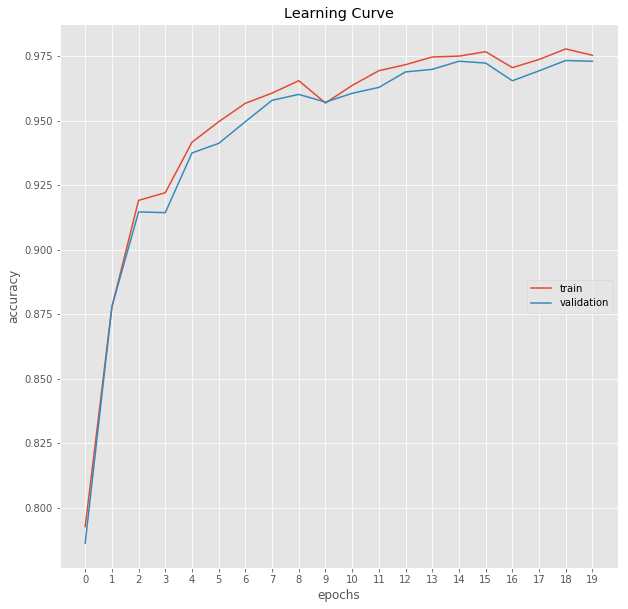

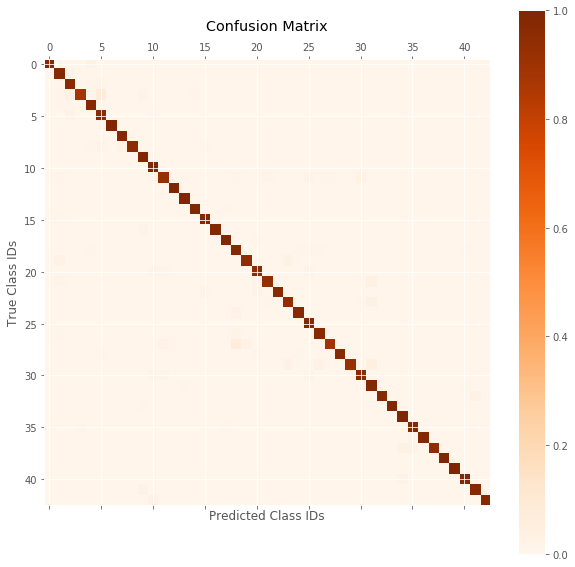

 6 End of speed limit (80km/h)                        100.00%  345
12 Priority road                                      100.00% 1725
13 Yield                                              100.00% 1774
34 Turn left ahead                                    100.00%  345
39 Keep left                                          100.00%  246
10 No passing for vehicles over 3.5 metric tons        99.72% 1651
17 No entry                                            99.49%  912
14 Stop                                                99.28%  641
33 Turn right ahead                                    99.19%  566
15 No vehicles                                         99.11%  518
38 Keep right                                          98.92% 1700
 9 No passing                                          98.85% 1208
16 Vehicles over 3.5 metric tons prohibited            98.67%  345
35 Ahead only                                          98.60%  986
36 Go straight or right                                98.57% 

In [98]:
show_learning_curve(learning_curve)
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network4())
    session.load('checkpoint/network4.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

##### Observations:
performance did not improved rather it got worse also Changing ReLU to ELU also didn't hepled to learn faster.<br>


## Network 5
Using maxpooling after relu in network3.

In [99]:
def make_network5(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .relu()     
            .max_pool() # <== after ReLU
            .conv([5, 5, 64])
            .relu()
            .max_pool() # <== after ReLU
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network5(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network5.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Training score: 0.813 Evaluation score: 0.810
Epoch:   1 Training score: 0.908 Evaluation score: 0.909
Epoch:   2 Training score: 0.938 Evaluation score: 0.935
Epoch:   3 Training score: 0.963 Evaluation score: 0.962
Epoch:   4 Training score: 0.968 Evaluation score: 0.967
Epoch:   5 Training score: 0.977 Evaluation score: 0.976
Epoch:   6 Training score: 0.981 Evaluation score: 0.981
Epoch:   7 Training score: 0.981 Evaluation score: 0.977
Epoch:   8 Training score: 0.980 Evaluation score: 0.977
Epoch:   9 Training score: 0.978 Evaluation score: 0.971
Epoch:  10 Training score: 0.986 Evaluation score: 0.979
Epoch:  11 Training score: 0.986 Evaluation score: 0.982
Epoch:  12 Training score: 0.988 Evaluation score: 0.986
Epoch:  13 Training score: 0.982 Evaluation score: 0.980
Epoch:  14 Training score: 0.989 Evaluation score: 0.985
Epoch:  15 Training score: 0.987 Evaluation score: 0.985
Epoch:  16 Training score: 0.991 Evaluation score: 0.986
Epoch:  17 Training score: 0.98

INFO:tensorflow:Restoring parameters from checkpoint/network5.ckpt


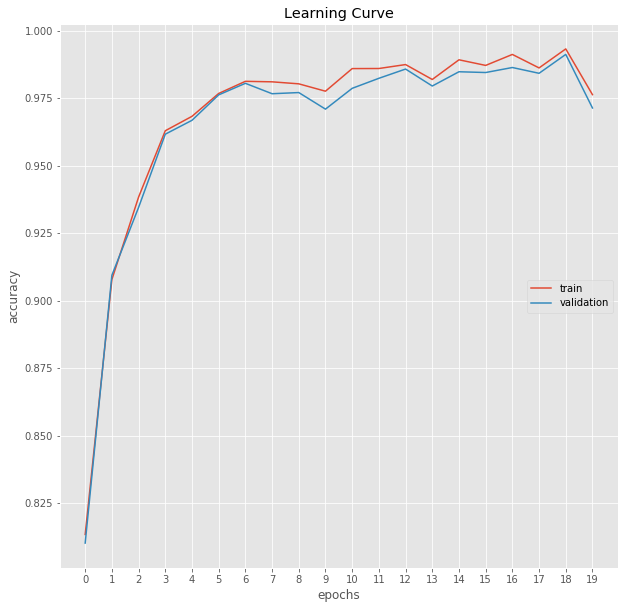

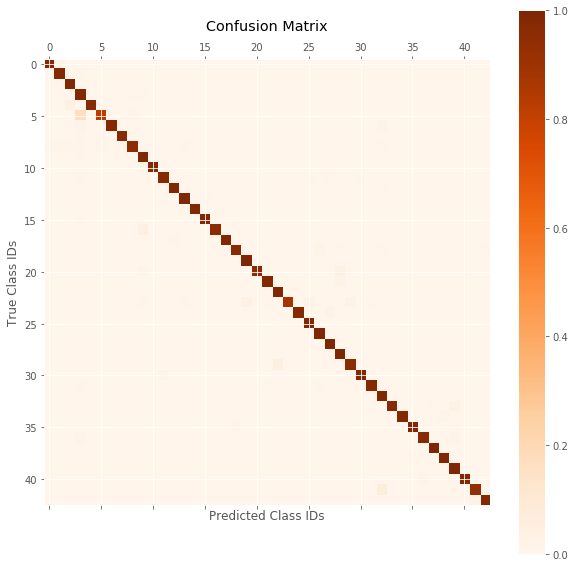

19 Dangerous curve to the left                        100.00%  172
22 Bumpy road                                         100.00%  320
26 Traffic signals                                    100.00%  493
27 Pedestrians                                        100.00%  197
28 Children crossing                                  100.00%  444
32 End of all speed and passing limits                100.00%  197
37 Go straight or left                                100.00%  172
39 Keep left                                          100.00%  246
17 No entry                                            99.49%  912
14 Stop                                                99.28%  641
 2 Speed limit (50km/h)                                99.25% 1848
25 Road work                                           99.25% 1232
 9 No passing                                          99.24% 1208
13 Yield                                               99.22% 1774
12 Priority road                                       99.20% 

In [100]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network5())
    session.load('checkpoint/network5.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

## Network 6
Let's try adding 3 conv layer.

In [101]:
def make_network6(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
            .input(input_shape)
            .conv([5, 5, 24])
            .max_pool()
            .relu()
            .conv([5, 5, 64])
            .max_pool()
            .relu()
            .conv([3, 3, 64])  # <= smaller kernel here (the image is small by here)
            .max_pool()
            .relu()
            .flatten()
            .dense(480)
            .relu()
            .dense(N_CLASSES))
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network6(), make_adam(0.5e-3))
    learning_curve = train_evaluate(pipeline, epochs=20)
    session.save('checkpoint/network6.ckpt')
    
show_learning_curve(learning_curve)

Epoch:   0 Training score: 0.819 Evaluation score: 0.815
Epoch:   1 Training score: 0.900 Evaluation score: 0.897
Epoch:   2 Training score: 0.945 Evaluation score: 0.943
Epoch:   3 Training score: 0.947 Evaluation score: 0.941
Epoch:   4 Training score: 0.956 Evaluation score: 0.954
Epoch:   5 Training score: 0.962 Evaluation score: 0.958
Epoch:   6 Training score: 0.967 Evaluation score: 0.962
Epoch:   7 Training score: 0.968 Evaluation score: 0.968
Epoch:   8 Training score: 0.969 Evaluation score: 0.967
Epoch:   9 Training score: 0.979 Evaluation score: 0.976
Epoch:  10 Training score: 0.980 Evaluation score: 0.979
Epoch:  11 Training score: 0.979 Evaluation score: 0.978
Epoch:  12 Training score: 0.981 Evaluation score: 0.980
Epoch:  13 Training score: 0.970 Evaluation score: 0.965
Epoch:  14 Training score: 0.981 Evaluation score: 0.980
Epoch:  15 Training score: 0.984 Evaluation score: 0.982
Epoch:  16 Training score: 0.983 Evaluation score: 0.981
Epoch:  17 Training score: 0.98

INFO:tensorflow:Restoring parameters from checkpoint/network6.ckpt


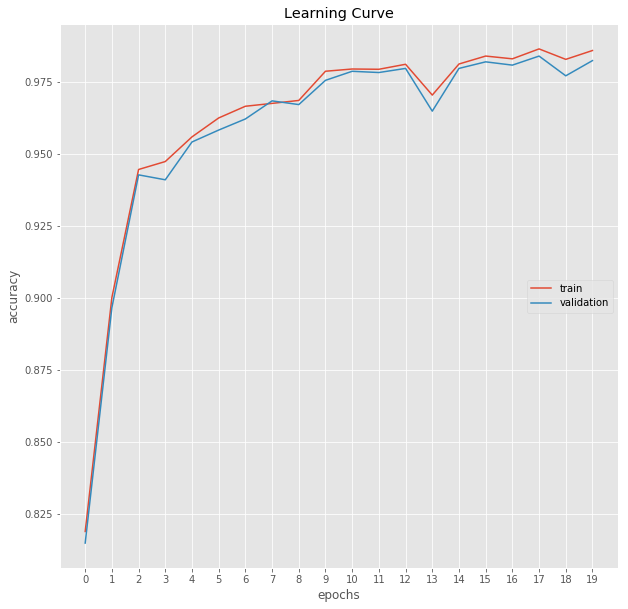

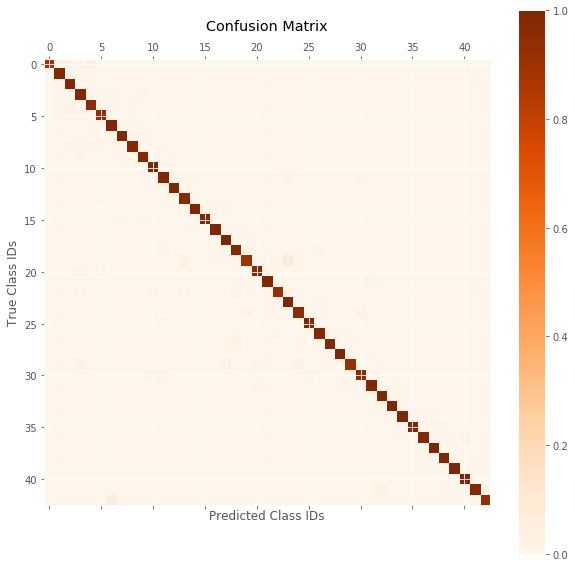

 6 End of speed limit (80km/h)                        100.00%  345
14 Stop                                               100.00%  641
16 Vehicles over 3.5 metric tons prohibited           100.00%  345
17 No entry                                           100.00%  912
23 Slippery road                                      100.00%  419
28 Children crossing                                  100.00%  444
32 End of all speed and passing limits                100.00%  197
33 Turn right ahead                                   100.00%  566
34 Turn left ahead                                    100.00%  345
37 Go straight or left                                100.00%  172
39 Keep left                                          100.00%  246
40 Roundabout mandatory                               100.00%  296
12 Priority road                                       99.73% 1725
10 No passing for vehicles over 3.5 metric tons        99.72% 1651
 7 Speed limit (100km/h)                               99.22% 

In [102]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network6())
    session.load('checkpoint/network6.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

In [104]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3(), make_adam(0.5e-3)) 
    learning_curve = train_evaluate(pipeline, epochs=100)
    session.save('checkpoint/network3_epochs-100_lr-1.0e-4.ckpt') 
    
show_learning_curve(learning_curve)

Epoch:   0 Training score: 0.817 Evaluation score: 0.810
Epoch:   1 Training score: 0.905 Evaluation score: 0.906
Epoch:   2 Training score: 0.943 Evaluation score: 0.943
Epoch:   3 Training score: 0.964 Evaluation score: 0.964
Epoch:   4 Training score: 0.967 Evaluation score: 0.966
Epoch:   5 Training score: 0.971 Evaluation score: 0.969
Epoch:   6 Training score: 0.972 Evaluation score: 0.970
Epoch:   7 Training score: 0.982 Evaluation score: 0.978
Epoch:   8 Training score: 0.977 Evaluation score: 0.972
Epoch:   9 Training score: 0.984 Evaluation score: 0.982
Epoch:  10 Training score: 0.987 Evaluation score: 0.984
Epoch:  11 Training score: 0.983 Evaluation score: 0.981
Epoch:  12 Training score: 0.986 Evaluation score: 0.985
Epoch:  13 Training score: 0.984 Evaluation score: 0.984
Epoch:  14 Training score: 0.988 Evaluation score: 0.986
Epoch:  15 Training score: 0.986 Evaluation score: 0.983
Epoch:  16 Training score: 0.984 Evaluation score: 0.979
Epoch:  17 Training score: 0.98

INFO:tensorflow:Restoring parameters from checkpoint/network3_epochs-100_lr-1.0e-4.ckpt


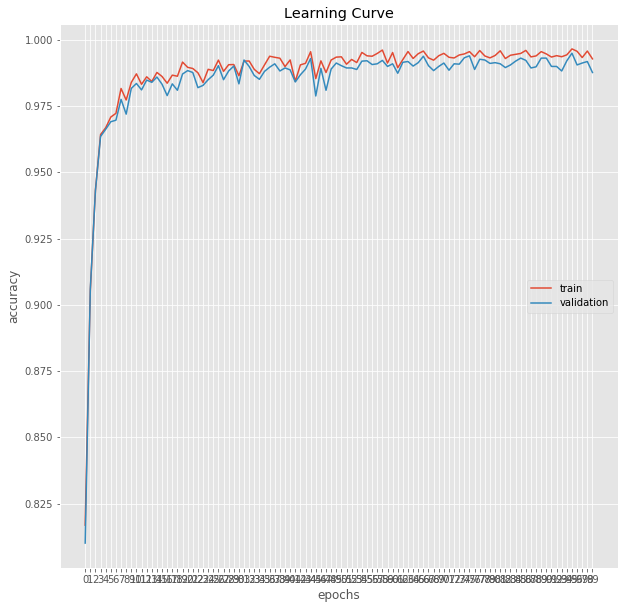

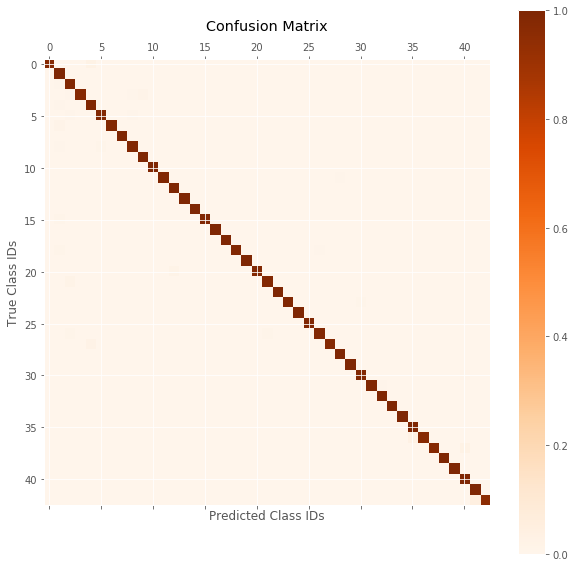

 9 No passing                                         100.00% 1208
14 Stop                                               100.00%  641
16 Vehicles over 3.5 metric tons prohibited           100.00%  345
17 No entry                                           100.00%  912
19 Dangerous curve to the left                        100.00%  172
22 Bumpy road                                         100.00%  320
24 Road narrows on the right                          100.00%  222
28 Children crossing                                  100.00%  444
29 Bicycles crossing                                  100.00%  222
32 End of all speed and passing limits                100.00%  197
33 Turn right ahead                                   100.00%  566
34 Turn left ahead                                    100.00%  345
35 Ahead only                                         100.00%  986
38 Keep right                                         100.00% 1700
39 Keep left                                          100.00% 

In [105]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_network3())
    session.load('checkpoint/network3_epochs-100_lr-1.0e-4.ckpt')  
    pred = pipeline.predict(X_valid)
    
# examine confusion_matrixix
cm = confusion_matrix(y_valid, pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)